In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import numpy as np
from PIL import Image
import ncem

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 0
sc.settings.figdir = figdir


# remove later
base_path = '/Users/anna.schaar/phd/'
datadir = base_path + "datasets/"

Running Scanpy 1.7.2, on 2021-06-21 11:45.


# MERFISH - brain

In [229]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='zhang',
    data_path=datadir + 'zhang/',
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


Trying to set attribute `.uns` of view, copying.


collecting image-wise celldata
adding graph-level covariates
Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'patient_col': 'mouse'}


### Figure 1: Modeling cell communication as spatial cell state dependencies.
#### UMAP mouse 1 slice 153 - Fig. 1b

n cells:  7439


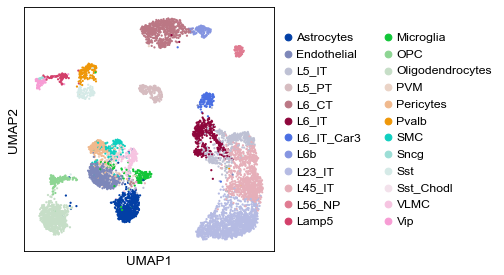

In [233]:
interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


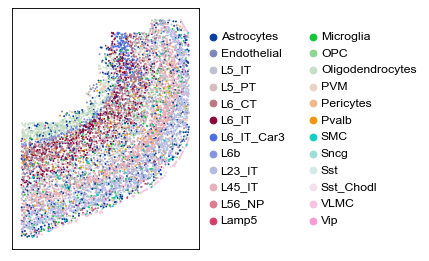

In [234]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True,
    copy=True
)

In [235]:
dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]

#### Example image 488 of mouse 1 slice 153 (dataset 1 sample 3) - Fig. 1b

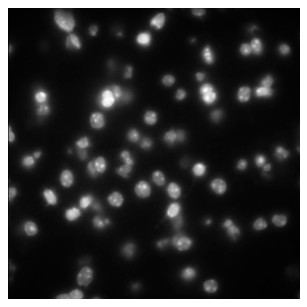

In [181]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))
img = sq.im.ImageContainer(images[:, :, 164])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

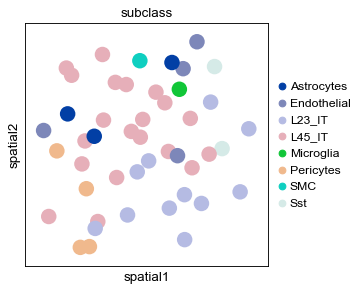

In [236]:
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']
sc.pl.spatial(
    dataset1_sample3_486, 
    spot_size=150, 
    color='subclass', 
)

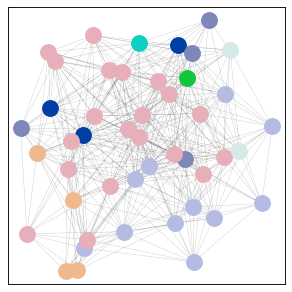

In [239]:
panel_width = 4.
panel_height = 4.
edge_width = 0.3

sc.set_figure_params(scanpy=True, fontsize=18)
plt.rcParams["axes.grid"] = False

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=(panel_width, panel_height))
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=200,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.set_position([box.x0, box.y0, box.width, box.height])
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
# plt.savefig("dataset1_sample3_488_graph_10um.pdf")

### Figure 2: Attributing cell heterogeneity to niche composition.
#### UMAP of L2/3 IT sub-states in slice 153 - Fig. 2 a

... storing 'L23_IT_substates' as categorical


n cells:  1204
L23_IT0    316
L23_IT1    314
L23_IT2    313
L23_IT3    133
L23_IT4    128
Name: L23_IT_substates, dtype: int64


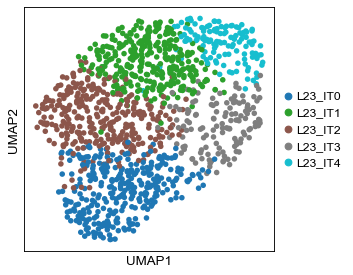

In [17]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L23_IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=12,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

Trying to set attribute `.uns` of view, copying.


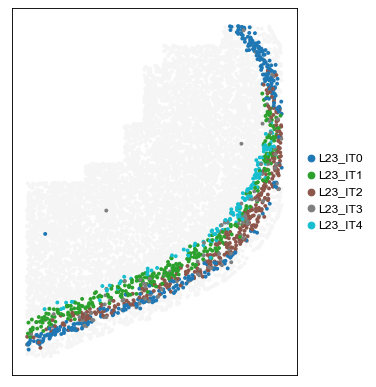

In [29]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L23_IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True
)

#### UMAPs of L2/3 IT neighbourhoods in slice 153 - Fig. 1c

In [61]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L45 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L56 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L23 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L23 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


n cells:  1204
L23 IT 0    316
L23 IT 1    314
L23 IT 2    313
L23 IT 3    133
L23 IT 4    128
Name: L23 IT_substates, dtype: int64


... storing 'fov' as categorical
... storing 'source type Astrocytes' as categorical
... storing 'source type Endothelial' as categorical
... storing 'source type L23 IT' as categorical
... storing 'source type L45 IT' as categorical
... storing 'source type L56 NP' as categorical
... storing 'source type L5 IT' as categorical
... storing 'source type L5 PT' as categorical
... storing 'source type L6 CT' as categorical
... storing 'source type L6 IT' as categorical
... storing 'source type L6 IT Car3' as categorical
... storing 'source type L6b' as categorical
... storing 'source type Lamp5' as categorical
... storing 'source type Microglia' as categorical
... storing 'source type OPC' as categorical
... storing 'source type Oligodendrocytes' as categorical
... storing 'source type PVM' as categorical
... storing 'source type Pericytes' as categorical
... storing 'source type Pvalb' as categorical
... storing 'source type SMC' as categorical
... storing 'source type Sncg' as categorica

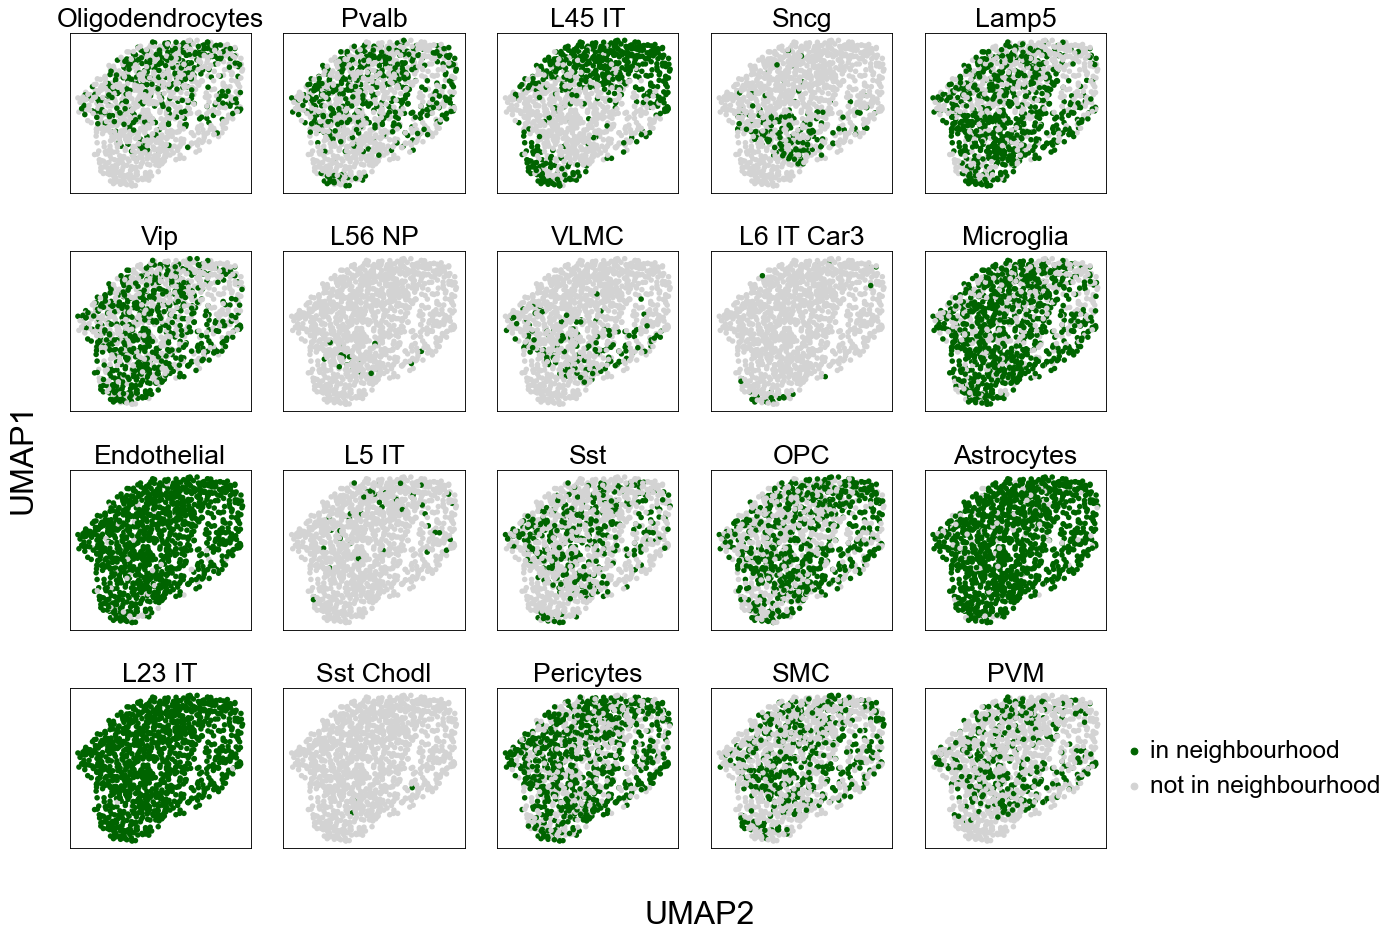

In [62]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

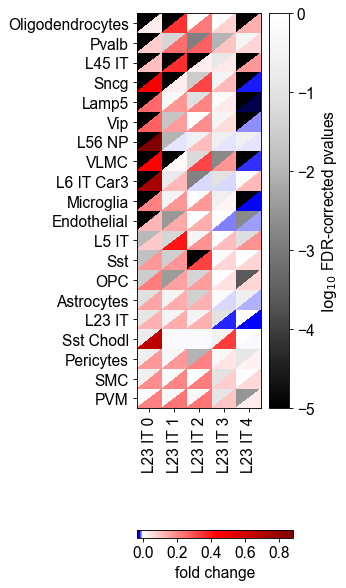

In [64]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14
)

### Variance decomposition - Supp. Fig. 4a

In [42]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')

100%|██████████| 64/64 [04:38<00:00,  4.35s/it]


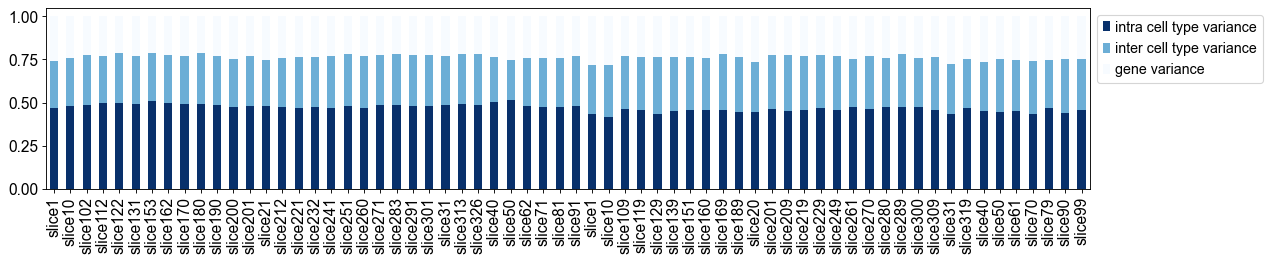

In [43]:
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

### Ligand-receptor analysis - Supp. Fig. 7a-b

n cells: 27638


  0%|          | 0/1000 [00:00<?, ?permutation/s]

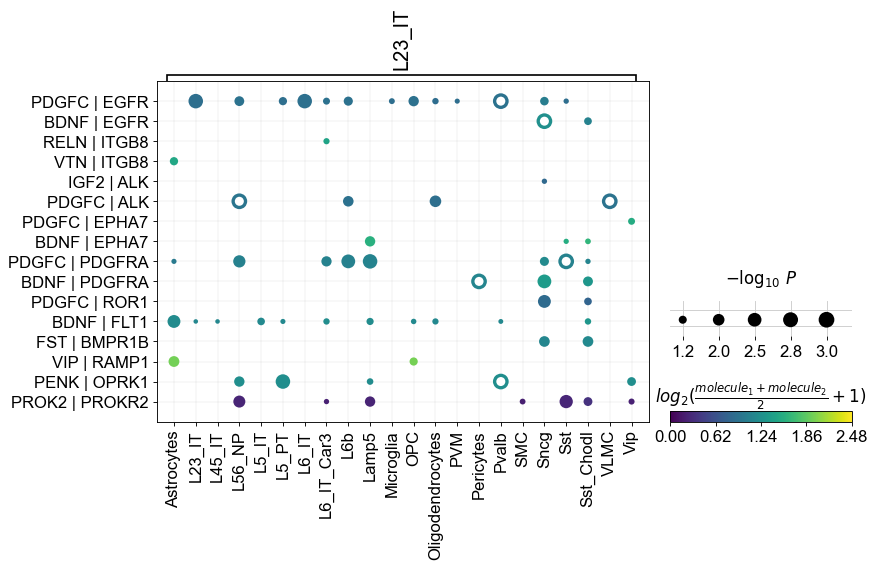

In [45]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L23_IT',
    undefined_type='other',
)

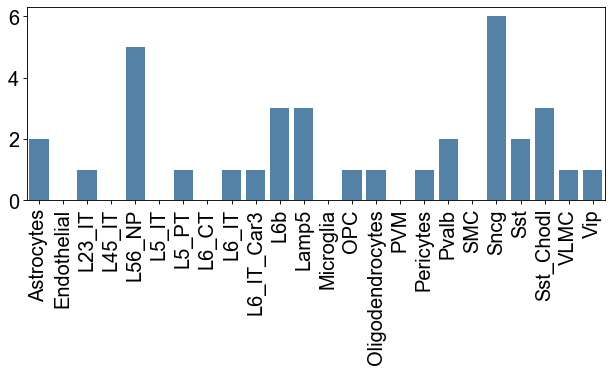

In [46]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L23_IT',
)

n cells: 7439


  0%|          | 0/1000 [00:00<?, ?permutation/s]

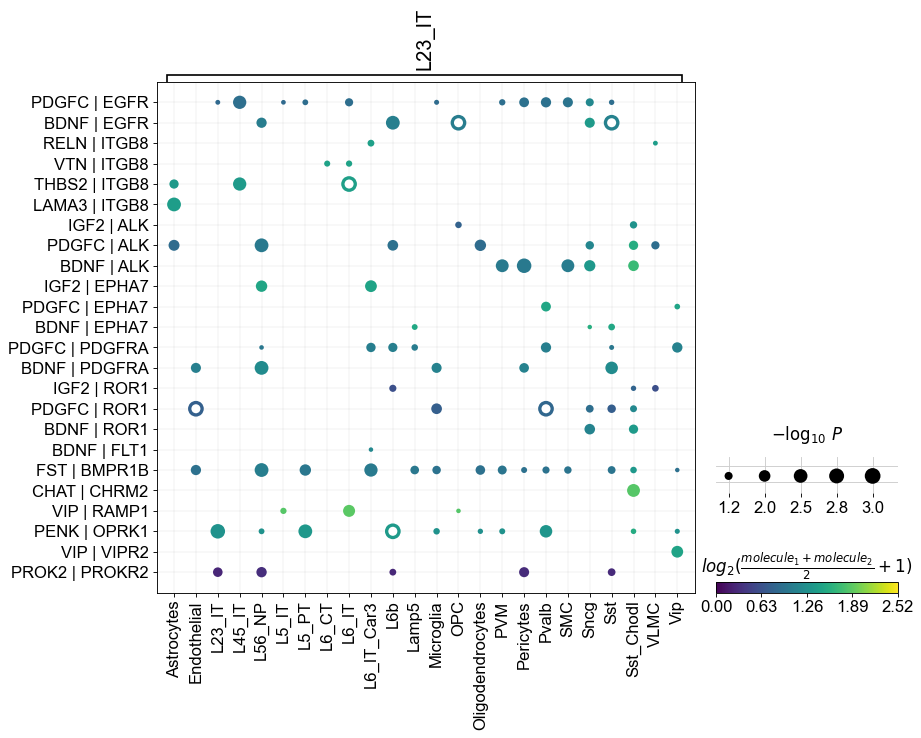

In [47]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L23_IT',
    undefined_type='other',
)

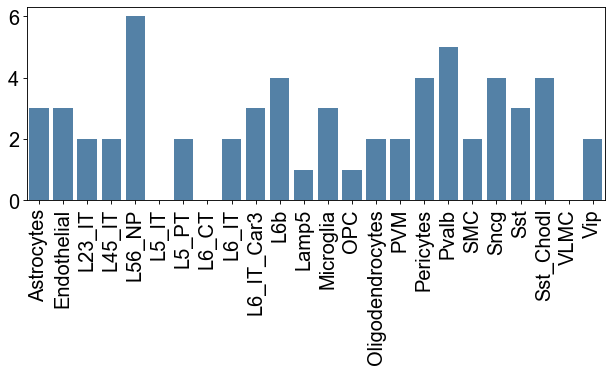

In [48]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L23_IT',
)

### Noise structure - Supp. Fig. 12a

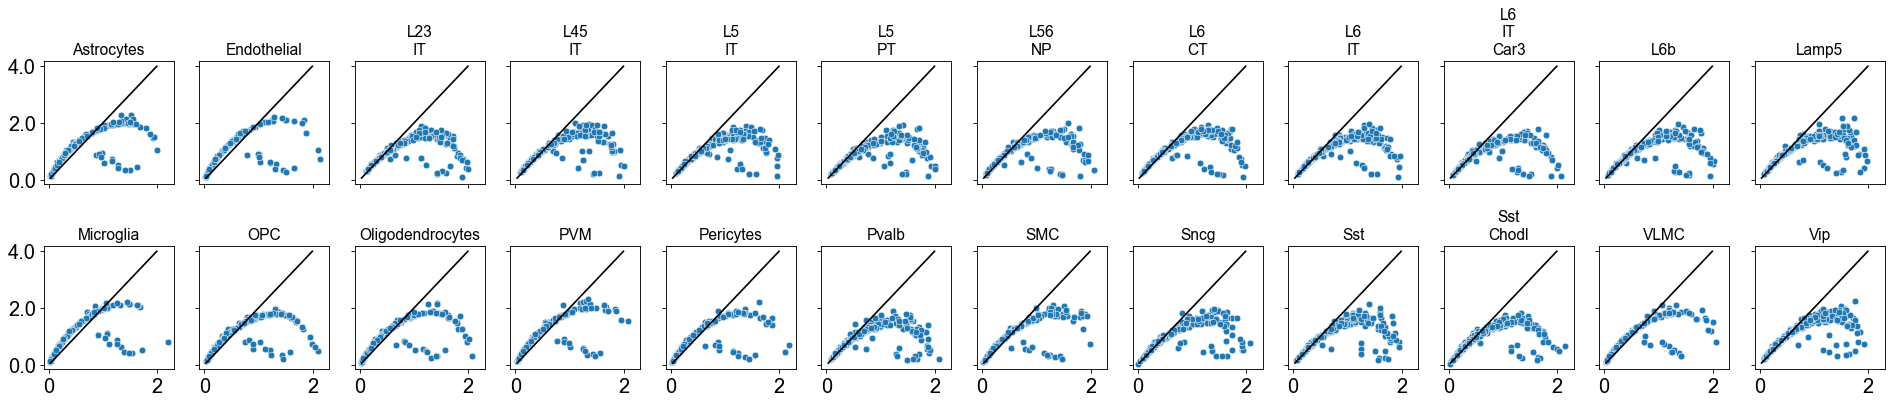

In [49]:
interpreter.data.noise_structure(undefined_type='other')

##  Replicate analysis for attribution of molecular states to neighborhoods in the MERFISH – brain data set. - Supp. Fig 5b-f

n cells:  6759


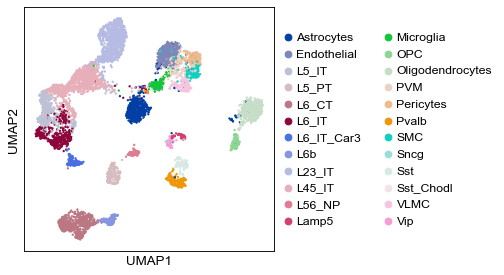

In [50]:
interpreter.data.umap(
    image_key= "mouse1_slice162",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


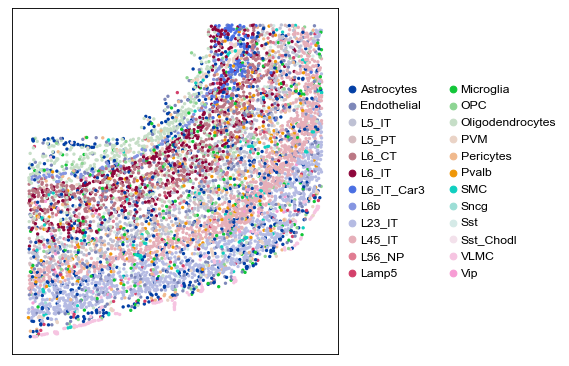

In [54]:
interpreter.data.spatial(
    image_key= "mouse1_slice162",
    undefined_type='other',
    fontsize=12,
    copy=False
)

... storing 'L23_IT_substates' as categorical


n cells:  946
L23_IT0    226
L23_IT1    209
L23_IT2    193
L23_IT3    191
L23_IT4    127
Name: L23_IT_substates, dtype: int64


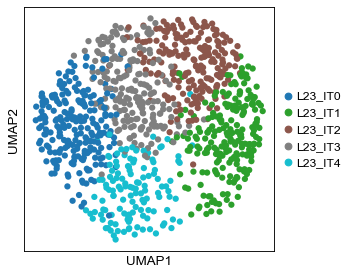

In [52]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L23_IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=12,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

Trying to set attribute `.uns` of view, copying.


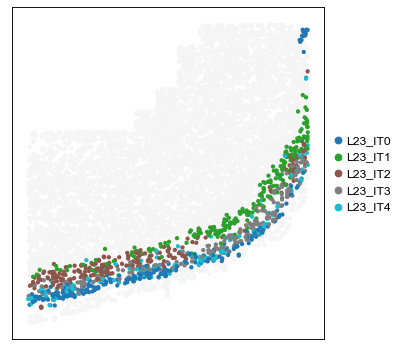

In [53]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L23_IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
)

In [55]:
filter_titles = ['L45 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L23 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice162',
    target_cell_type='L23 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


n cells:  946
L23 IT 0    226
L23 IT 1    209
L23 IT 2    193
L23 IT 3    191
L23 IT 4    127
Name: L23 IT_substates, dtype: int64


... storing 'fov' as categorical
... storing 'source type Astrocytes' as categorical
... storing 'source type Endothelial' as categorical
... storing 'source type L23 IT' as categorical
... storing 'source type L45 IT' as categorical
... storing 'source type L56 NP' as categorical
... storing 'source type L5 IT' as categorical
... storing 'source type L5 PT' as categorical
... storing 'source type L6 CT' as categorical
... storing 'source type L6 IT' as categorical
... storing 'source type L6 IT Car3' as categorical
... storing 'source type L6b' as categorical
... storing 'source type Lamp5' as categorical
... storing 'source type Microglia' as categorical
... storing 'source type OPC' as categorical
... storing 'source type Oligodendrocytes' as categorical
... storing 'source type PVM' as categorical
... storing 'source type Pericytes' as categorical
... storing 'source type Pvalb' as categorical
... storing 'source type SMC' as categorical
... storing 'source type Sncg' as categorica

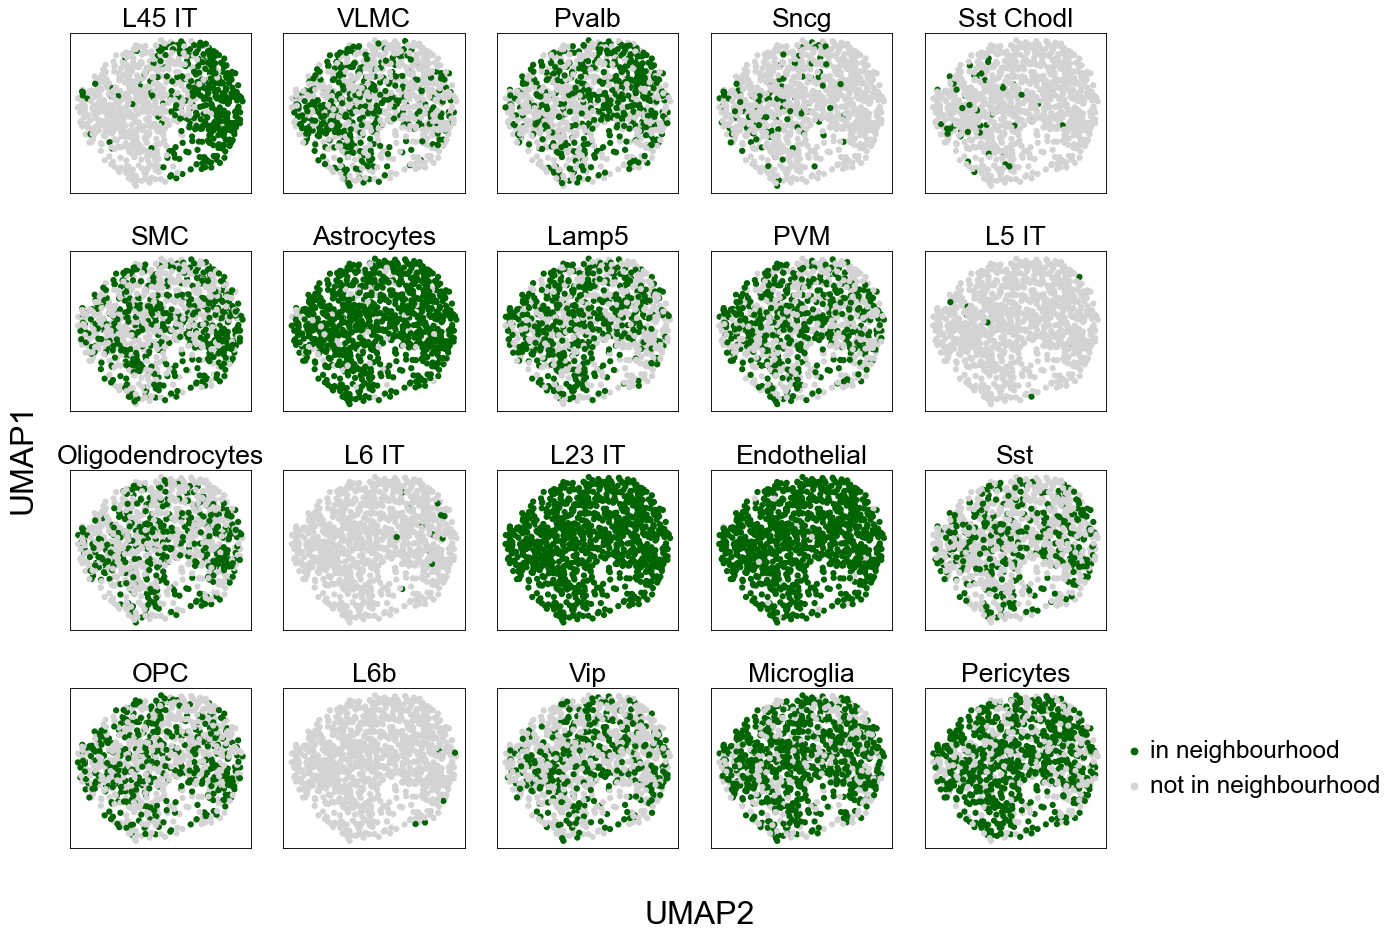

In [56]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

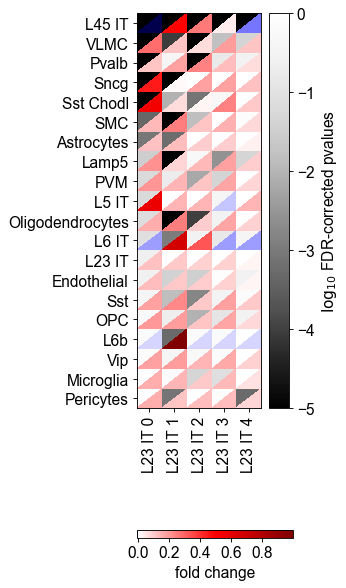

In [60]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14
)

# Chip Cytometry - colon

In [65]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='jarosch',
    data_path=datadir + 'jarosch/',
    radius=40,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Trying to set attribute `.uns` of view, copying.


Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 13 distinct celltypes.
Mean of mean node degree per images across images: 4.883873

 Celldata metadata: {'lateral_resolution': 0.5, 'fn': 'raw_inflamed_colon_1.h5ad', 'image_col': 'Annotation', 'pos_cols': ['X', 'Y'], 'cluster_col': 'celltype_Level_2', 'patient_col': None}


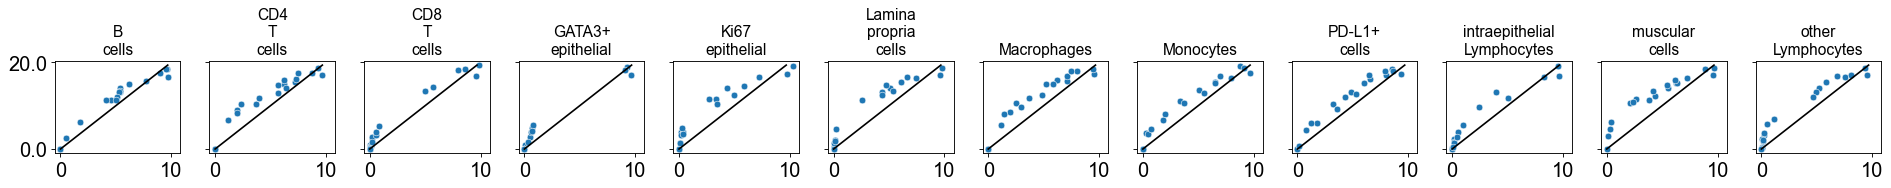

In [67]:
interpreter.data.noise_structure()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 11321


  0%|          | 0/1000 [00:00<?, ?permutation/s]

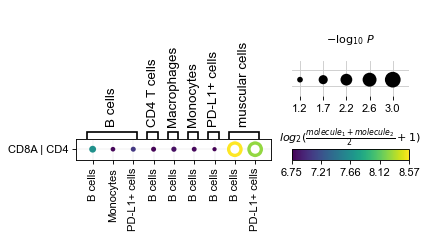

In [69]:
hgnc_names = [
    'CD14', 
    'MS4A1', 
    'IL2RA', 
    'CD3G', 
    'CD4', 
    'PTPRC',
    'PTPRC',
    'PTPRC',
    'CD68', 
    'CD8A', 
    'KRT5', # 'KRT1', 'KRT14'
    'FOXP3', 
    'GATA3', 
    'MKI67', 
    'Nuclei',
    'PDCD1', 
    'CD274', 
    'SMN1', 
    'VIM'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    seed=10,
    fontsize=12,
    width=2.
)

100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


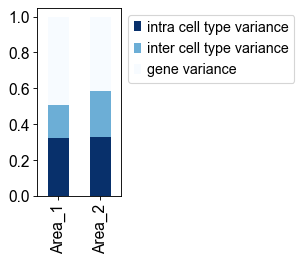

In [76]:
var_decomp = interpreter.data.compute_variance_decomposition()
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    multiindex=False
)

# MIBI TOF - cancer

In [95]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='hartmann',
    data_path=datadir + 'hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates
Loaded 58 images with complete data from 4 patients over 63734 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416425

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'patient_col': 'donor'}


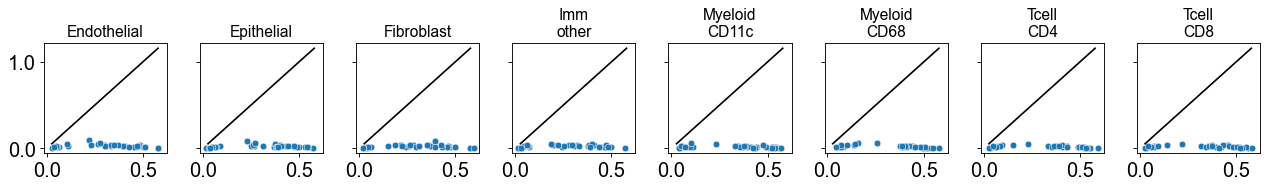

In [79]:
interpreter.data.noise_structure()

n cells: 25493


  0%|          | 0/1000 [00:00<?, ?permutation/s]

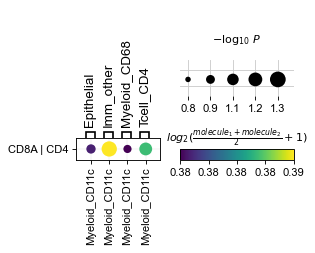

In [81]:
hgnc_names = [
    'H3-4', 
    'VIM', 
    'SMN1', 
    'SLC3A2', 
    'NFE2L2', 
    'CD4', 
    'CD14', 
    'PTPRC', 
    'PDCD1',
    'PECAM1', 
    'SDHA', 
    'MKI67', 
    'CS', 
    'RPS6', 
    'ITGAX', 
    'CD68', 
    'CD36', 
    'ATP5F1A',
    'CD247', 
    'ENTPD1', 
    'VDAC1', 
    'G6PD', 
    'XBP1', 
    'PKM', 
    'SLC1A5', 
    'SLC2A1', 
    'CD8A',
    'B3GAT1', 
    'LDHA', 
    'IDH2', 
    'HK1', 
    'CDH1', 
    'CPT1A', 
    'CKM', 
    'ATP1A1',
    'HIF1A'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    fraction=0.40,
    fontsize=12,
    width=2.,
)

100%|██████████| 58/58 [00:35<00:00,  1.63it/s]


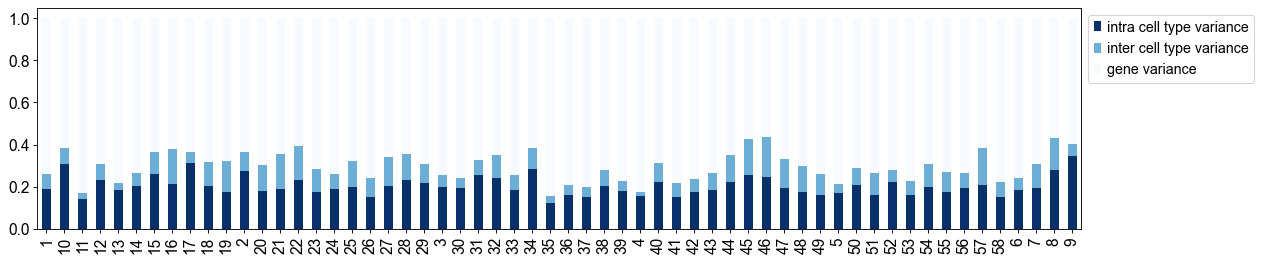

In [99]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    #panel_width=4,
    #multiindex=False
)

In [84]:
interpreter.data.celldata

AnnData object with n_obs × n_vars = 63734 × 36
    obs: 'point', 'cell_id', 'donor', 'Cluster'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates'
    obsm: 'spatial', 'node_types'

# MELC - tonsils data

In [240]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='pascualreguant',
    data_path=datadir + 'pascualreguant/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 1 images with complete data from 1 patients over 6991 cells with 51 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 19.083107

 Celldata metadata: {'lateral_resolution': 0.325, 'fn': ['TONSIL_MFI_nuclei_data_table.xlsx', 'TONSIL_MFI_membranes_data_table.xlsx'], 'image_col': 'img_keys', 'pos_cols': ['Location_Center_X', 'Location_Center_Y'], 'cluster_col': 'cell_class', 'patient_col': None}


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


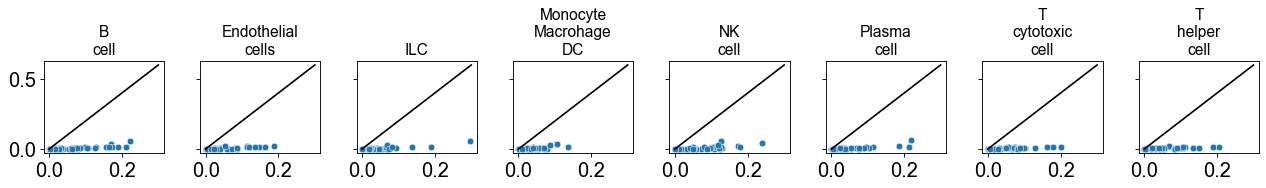

In [242]:
interpreter.data.noise_structure(
    undefined_type='other',
    min_x=0.0, max_x=0.3
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 4470


  0%|          | 0/1000 [00:00<?, ?permutation/s]

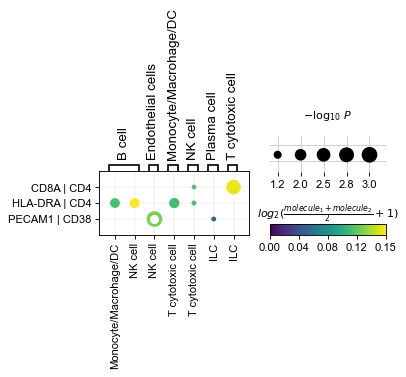

In [243]:
hgnc_names = [
    'BCL6', 
    'FOXP3', 
    'IKZF2', 
    'IRF4', 
    'MKI67', 
    'PAX5', 
    'CCR6', 
    'ITGAE',
    'ITGAX', 
    'IL3RA', 
    'IL7R', 
    'SDC1', 
    'CD14', 
    'THBD', 
    'FCGR3A', 
    'KLRB1',
    'CD19', 
    'MS4A1', 
    'CR2', 
    'FCER2', 
    'CD247', 
    'PECAM1', 
    'CD34', 
    'CD38', 
    'CD4',
    'PTPRC', 
    'PTPRC', 
    'PTPRC', 
    'ITGA1', 
    'NCAM1', 
    'CD69', 
    'CD7', 
    'CD8A',
    'KLRD1', 
    'CXCR3', 
    'FCER1A', 
    'GZMA', 
    'HLA-DRA', 
    'ICOS', 
    'CD79A', 
    'IGHG1',
    'IGHM', 
    'CD207', 
    'NCR2', 
    'TNFSF11', 
    'SMN1', 
    'TCRVa72', ## 
    'TRG', 
    'VCAM1',
    'VIM', 
    'KIT'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='other',
    fontsize=12,
    width=2.,
)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


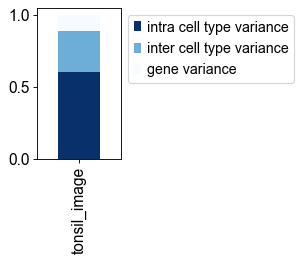

In [246]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    #multiindex=False
)

# CODEX - cancer

In [247]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='schuerch',
    data_path=datadir + 'schuerch/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 29 distinct celltypes.
Mean of mean node degree per images across images: 10.311835

 Celldata metadata: {'lateral_resolution': 0.377442, 'fn': 'CRC_clusters_neighborhoods_markers_NEW.csv', 'image_col': 'File Name', 'pos_cols': ['X:X', 'Y:Y'], 'cluster_col': 'ClusterName', 'patient_col': 'patients'}


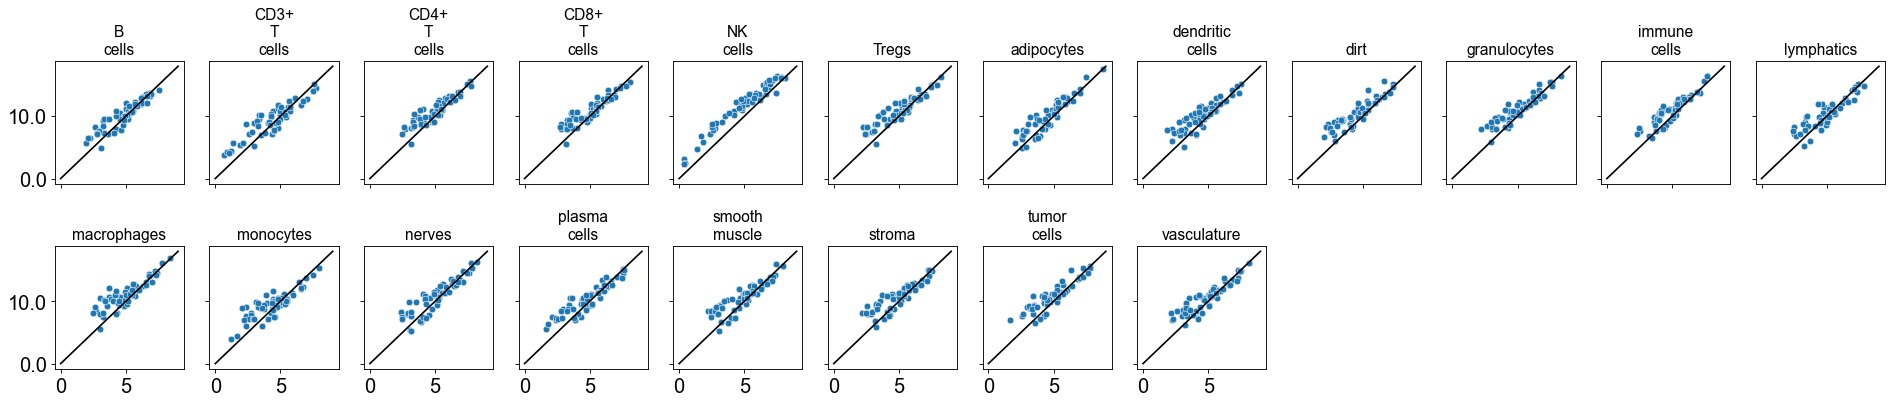

In [248]:
interpreter.data.noise_structure(
    undefined_type='undefined',
    min_x=0.0, max_x=9.
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 25226


  0%|          | 0/1000 [00:00<?, ?permutation/s]

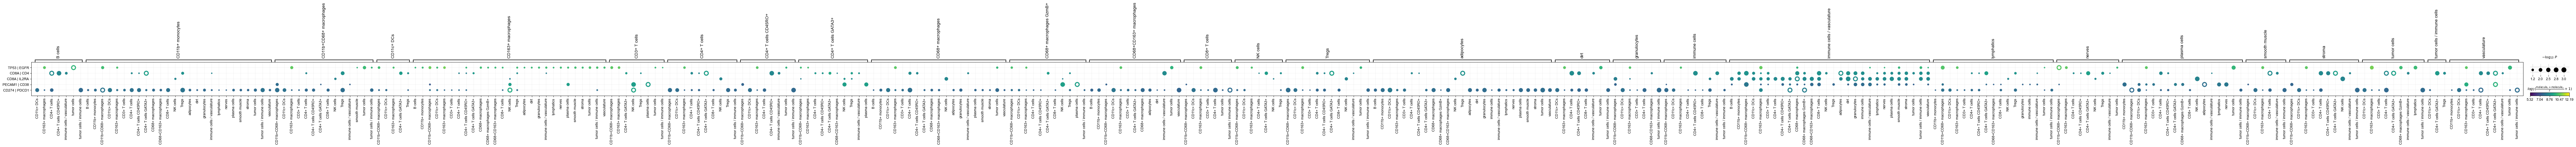

In [249]:
hgnc_names = [
    'CD44', 
    'FOXP3', 
    'CD8A', 'TP53', 
    'GATA3', 
    'PTPRC', 
    'TBX21', 
    'CTNNB1',
    'HLA-DR', 
    'CD274', 
    'MKI67', 
    'PTPRC', 
    'CD4', 
    'CR2', 
    'MUC1', 
    'TNFRSF8',
    'CD2', 
    'VIM', 
    'MS4A1', 
    'LAG3', 
    'ATP1A1', 
    'CD5', 
    'IDO1',
    'KRT1', 
    'ITGAM', 
    'NCAM1', 
    'ACTA1', 
    'BCL2', 
    'IL2RA', 
    'ITGAX',
    'PDCD1', 
    'GZMB', 
    'EGFR', 
    'VISTA', 
    'FUT4', 
    'ICOS', 
    'SYP',
    'GFAP', 
    'CD7', 
    'CD247', 
    'CHGA', 
    'CD163', 
    'PTPRC', 
    'CD68',
    'PECAM1', 
    'PDPN', 
    'CD34', 
    'CD38', 
    'SDC1', 
    'HOECHST1:Cyc_1_ch_1', ##
    'CDX2', 
    'COL6A1', 
    'CCR4', 
    'MMP9', 
    'TFRC', 
    'B3GAT1', 
    'MMP12'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='undefined',
    fraction=0.1,
    fontsize=12,
    width=2.,
)

100%|██████████| 140/140 [02:33<00:00,  1.09s/it]


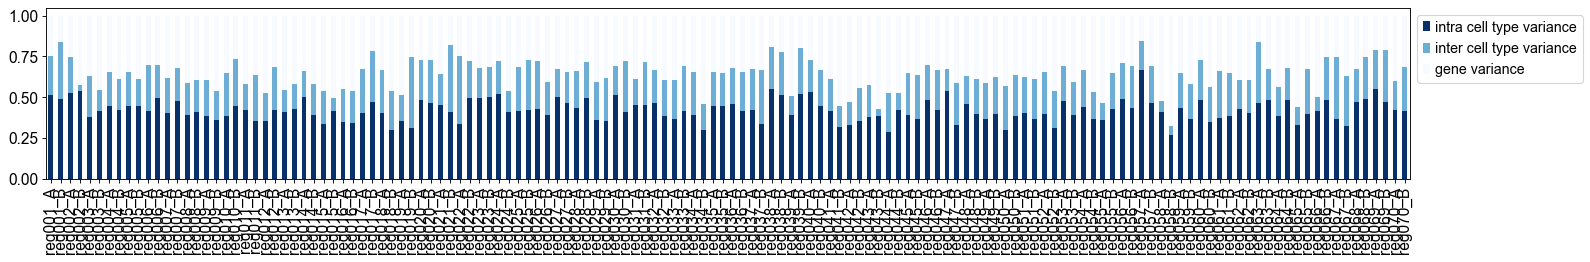

In [250]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='undefined')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=20,
    #multiindex=False
)